In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import os

In [344]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, average_precision_score
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import classification_report
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
linewidth = 4

In [164]:
os.listdir('../data')

['.DS_Store',
 'data_augmentation',
 'pickle_files',
 'bank-additional-names.txt',
 '.ipynb_checkpoints',
 'bank-additional.zip',
 'bank-additional.csv',
 'bank-additional-full.csv']

In [169]:
d = pd.read_csv('../data/bank-additional-full.csv', sep = ";")

In [168]:
d.columns

Index(['age;"job";"marital";"education";"default";"housing";"loan";"contact";"month";"day_of_week";"duration";"campaign";"pdays";"previous";"poutcome";"emp.var.rate";"cons.price.idx";"cons.conf.idx";"euribor3m";"nr.employed";"y"'], dtype='object')

In [5]:
#Loading df1 after it has been augmented in iteration 2:
df = pd.read_pickle('../data/pickle_files/df_pickle_w_all_stats')
#Excluding the duration variable as it cannot be used in our baseline
#df = df.drop(columns = ['duration'])

In [6]:
y = df['y']
#X = df.drop(columns='y')
names = list(df.columns)

In [7]:
df.columns

Index(['cons_conf', 'ind_turnover', 'major_purch_expect',
       'major_purch_opportu', 'unempl_expect', 'inflation_delta_expect',
       'economy_expect', 'economy_past', 'financial_past',
       'savings_delta_expect', 'household_debt_ratio', 'savings_expect',
       'emplmnt_industry_index', 'railway_passengers', 'month', 'year', 'Date',
       'day', 'age', 'duration', 'campaign', 'pdays', 'previous',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month_last_contact', 'day_of_week_last_contact',
       'poutcome', 'y', 'Consumer credit', 'Deposit interest rate',
       'Mortgage credit interest rate', 'Business credit interest rate',
       'Employment', 'Unemployment rate', 'Current account balance', 'Exports',
       'FDI', 'Foreign exchange reserves', 'Government expenditure',
       'Budget balance', 'Labor cost', 'Exchange rate to USD', 'Minimum wage',


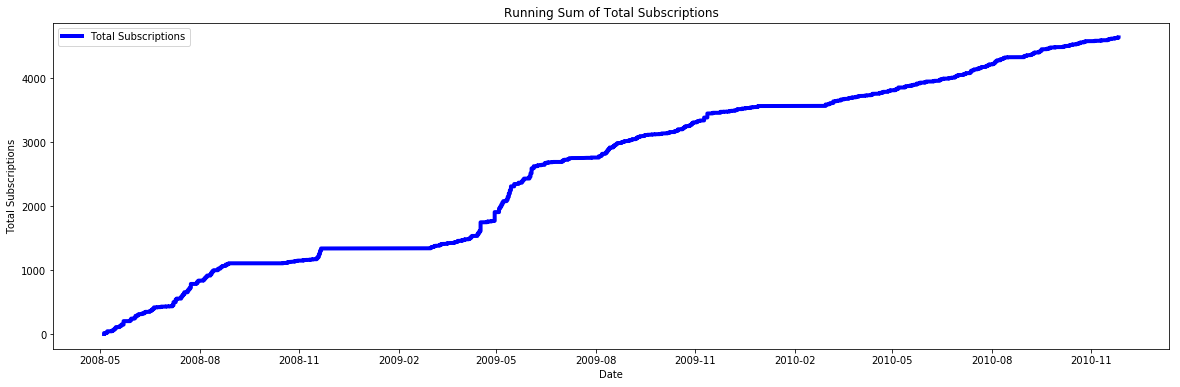

In [345]:
plt.figure(figsize=(20,6))
plt.title("Running Sum of Total Subscriptions")
plt.xlabel("Date")
plt.ylabel("Total Subscriptions")
plt.plot(df.Date, np.cumsum(y), c='blue', label='Total Subscriptions', linewidth = linewidth)
plt.legend()
plt.show()

In [26]:
len(df[df.pdays==999])

39673

In [182]:
#Checking the definition of New Lead, New Prospect, Old Prospect:
print("Data quality check on definition of New Lead: ")
if (len(df[(df.previous ==0)&(df.campaign==1)&(df.pdays==999)])==len(df[(df.previous ==0)&(df.campaign==1)])) == True:
    print('Passed')
#New prospect check
print("Data quality check on definition of New Prospect: ")
if (len(df[(df.previous ==0)&(df.campaign>1)&(df.pdays==999)])==len(df[(df.previous ==0)&(df.campaign>1)])) == True:
    print('Passed')

Data quality check on definition of New Lead: 
Passed
Data quality check on definition of New Prospect: 
Passed


A simple quality check on the old prospects shows that people who have more than zero number of attempts in previous campaigns have a pday value of 999. This would seem contrdictory since the value is only applied to clients who were not previously contacted. A check with a business analyst confirms this is possible and these instances reprensent inbound calls. These clients will remain tagged as old prospects, but their pday value will need to be taken into account when modeling for them

Notice we cannot create an inbound/outbound flag solely relying on this because other with attempts may have been inbound as well

In [181]:
#print("Old prospects: ")
print("Number of old prospects who were never contacted as part of a previous campaign")
len(df[(df.previous >0)&(df.pdays == 999)])

4110

Attempts Categories:

- Attempt: any contact with any lead or customer
- New Lead: someone who has never been contacted before
- New Prospect: someone who has been contacted only as current campaign
- Old Prospect: someone who has been contacted only in past campaign

- Leads and New/Old prospects are mutually exclusive

In [73]:
print("New leads: ", len(df[(df.previous ==0)&(df.campaign==1)]))
print("New prospects: ", len(df[(df.previous ==0)&(df.campaign>1)]))
print("Old prospects: ", len(df[(df.previous >0)]))
print("Attempts:", len(df))

New leads:  14791
New prospects:  20772
Old prospects:  5625
Attempts: 41188


In [83]:
print("New leads % of total: ", len(df[(df.previous ==0)&(df.campaign==1)])/len(df))
print("New prospects % of total: ", len(df[(df.previous ==0)&(df.campaign>1)])/len(df))
print("Old prospects % of total: ", len(df[(df.previous >0)])/len(df))

New leads % of total:  0.3591094493541808
New prospects % of total:  0.5043216470816743
Old prospects % of total:  0.1365689035641449


In [74]:
#Sum of the two below adds up to total Old Prospects
print("Old prospects who were old prospects in prior campaign : ", len(df[(df.previous >0)&(df.pdays!=999)]))
print("Old prospects who were new leads in prior campaign : ", len(df[(df.previous >0)&(df.pdays==999)]))

Old prospects who were old prospects in prior campaign :  1515
Old prospects who were new leads in prior campaign :  4110


In [75]:
print("Old prospects contacted in current campaign: ", len(df[(df.previous>0)&(df.pdays!=999)&(df.campaign>1)]))
print("Old prospects not contacted in current campaign: ", len(df[(df.previous>0)&(df.pdays!=999)&(df.campaign==1)]))

Old prospects contacted in current campaign:  718
Old prospects not contacted in current campaign:  797


In [88]:
df['new_lead'] = np.where((df.previous ==0)&(df.campaign==1),1,0)
#Simple check
#len(df[df['new_lead']==1])

In [90]:
df['new_prospect'] = np.where((df.previous ==0)&(df.campaign>1),1,0)
#Simple check
#len(df[df['new_prospect']==1])

In [93]:
df['old_prospect'] = np.where((df.previous > 0),1,0)
#Simple check
#len(df[df['old_prospect']==1])

In [365]:
#helper method to trace back category variables
def cat_lookup(d,df, col):
    #print("Category Codes for %s"%(col))
    cats_job = dict(zip(d[col], df[col].astype('category').cat.codes))
    #print(sorted(cats_job.items(), key = lambda x: x[1]))
    return list(sorted(cats_job.items(), key = lambda x: x[1]))

In [366]:
cat_lookup(d,df, "poutcome")

[('failure', 0), ('nonexistent', 1), ('success', 2)]

In [ ]:
#Do basic data analysis for these three cats here

Create Customer ID's:

In [136]:
#last contact month and actual month are different - this has big significance 
#because it means the term "last contact" is not used to describe the call when it occurs
#but to describe the latest call before the current call recorded by the table i.e. each table instance
np.where((df.month_last_contact == df.month),1,0).sum()

544

In [84]:
df.columns

Index(['cons_conf', 'ind_turnover', 'major_purch_expect',
       'major_purch_opportu', 'unempl_expect', 'inflation_delta_expect',
       'economy_expect', 'economy_past', 'financial_past',
       'savings_delta_expect', 'household_debt_ratio', 'savings_expect',
       'emplmnt_industry_index', 'railway_passengers', 'month', 'year', 'Date',
       'day', 'age', 'duration', 'campaign', 'pdays', 'previous',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month_last_contact', 'day_of_week_last_contact',
       'poutcome', 'y', 'Consumer credit', 'Deposit interest rate',
       'Mortgage credit interest rate', 'Business credit interest rate',
       'Employment', 'Unemployment rate', 'Current account balance', 'Exports',
       'FDI', 'Foreign exchange reserves', 'Government expenditure',
       'Budget balance', 'Labor cost', 'Exchange rate to USD', 'Minimum wage',


In [238]:
#number of new customers who subscribe
print("Number of new lead attempts that yield subscribe: ", len(df[(df['new_lead'] == 1) & (df['y'] == 1)]))
print("Number of new lead attempts that yield subscribe: ", len(df[(df['new_lead'] == 1) & (df['y'] == 0)]))

Number of new lead attempts who subscribe:  1491
Number of new lead attempts who don't subscribe:  13300


In [246]:
#number of new customers who subscribe
print("Number of new prospect attempts that yield subscribe: ", len(df[(df['new_prospect'] == 1) & (df['y'] == 1)]))
print("Number of new prospect attempts that yield don't subscribe: ", len(df[(df['new_prospect'] == 1) & (df['y'] == 0)]))

Number of new prospect attempts that yield subscribe:  1650
Number of new prospect attempts that yield don't subscribe:  19122


In [245]:
#number of new customers who subscribe
print("Number of old prospect attempts that yield subscribe: ", len(df[(df['old_prospect'] == 1) & (df['y'] == 1)]))
print("Number of old prospect attempts that yield don't subscribe: ", len(df[(df['old_prospect'] == 1) & (df['y'] == 0)]))

Number of old prospect attempts that yield subscribe:  1499
Number of old prospect attempts that yield don't subscribe:  4126


In [247]:
print("New lead attempt subscriptions as a % of total attempts: ", len(df[(df['new_lead'] == 1) & (df['y'] == 1)])/len(df))
print("New prospect attempt subscriptions as a % of total attempts: ", len(df[(df['new_prospect'] == 1) & (df['y'] == 1)])/len(df))
print("Old prospect attempt subscriptions as a % of total attempts: ", len(df[(df['old_prospect'] == 1) & (df['y'] == 1)])/len(df))

New lead attempt subscriptions as a % of total attempts:  0.03619986403806934
New prospect attempt subscriptions as a % of total attempts:  0.04006021171214917
Old prospect attempt subscriptions as a % of total attempts:  0.03639409536758279


In [248]:
print("New lead subscriptions as a % of subscriptions: ", len(df[(df['new_lead'] == 1) & (df['y'] == 1)])/len(df[df['y']==1]))
print("New prospect subscriptions as a % of subscriptions: ", len(df[(df['new_prospect'] == 1) & (df['y'] == 1)])/len(df[df['y']==1]))
print("Old prospect subscriptions as a % of subscriptions: ", len(df[(df['old_prospect'] == 1) & (df['y'] == 1)])/len(df[df['y']==1]))

New lead subscriptions as a % of subscriptions:  0.32133620689655173
New prospect subscriptions as a % of subscriptions:  0.35560344827586204
Old prospect subscriptions as a % of subscriptions:  0.3230603448275862


In [299]:
#Creating running sum of y for convenience
df['cum_sum_y'] = np.cumsum(df['y'])

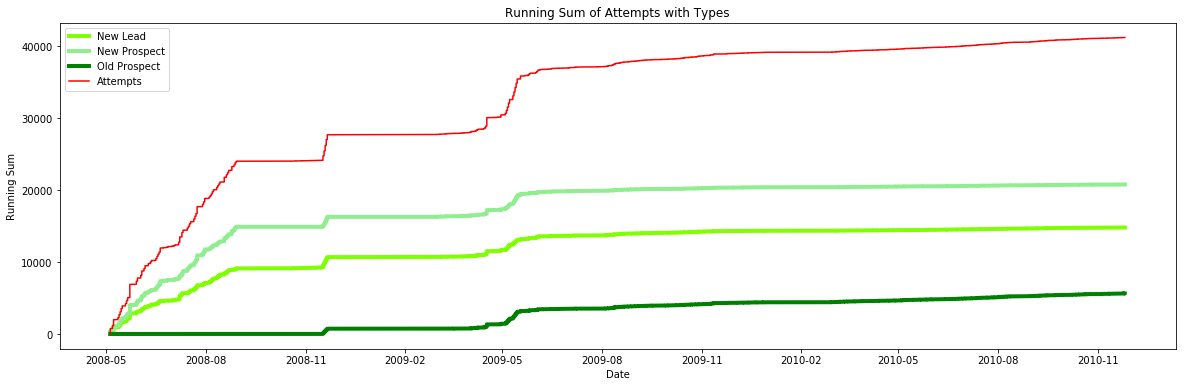

In [346]:
plt.figure(figsize=(20,6))
plt.title("Running Sum of Attempts with Types")
plt.xlabel("Date")
plt.ylabel("Running Sum")
#plt.plot(df.Date, np.cumsum(y), c='blue', label='Subscriptions')
plt.plot(df.Date, np.cumsum(df['new_lead'] == 1), c = 'chartreuse', label = 'New Lead', linewidth = linewidth)
plt.plot(df.Date, np.cumsum(df['new_prospect'] == 1), c = 'lightgreen', label = 'New Prospect', linewidth = linewidth)
plt.plot(df.Date, np.cumsum(df['old_prospect'] == 1), c = 'green', label = 'Old Prospect', linewidth = linewidth)
plt.plot(df.Date, df.index, c='red', label='Attempts')
plt.legend()
#plt.plot(df.Date, np.cumsum(df.repeat_customer)/np.cumsum(df.new_customer), c='yellow')
plt.show()

In [255]:
new_byage = pd.concat([df[['new_lead', 'age']].groupby(['new_lead']).mean(), df[['new_lead', 'age']].groupby(['new_lead']).std()], axis=1)
new_byage.columns = ['Age Mean', 'Age Stdev']

In [256]:
new_byage

,Age Mean,Age Stdev
new_lead,,
0,40.037,10.540
1,40.002,10.206


In [257]:
count, bin_edges = np.histogram(df['age'])

In [258]:
y1 = df['age']
y2 = df[df['y'] == 1]['age']
y3 = df[(df['y'] == 1)&(df['new_lead'] == 1)]['age']

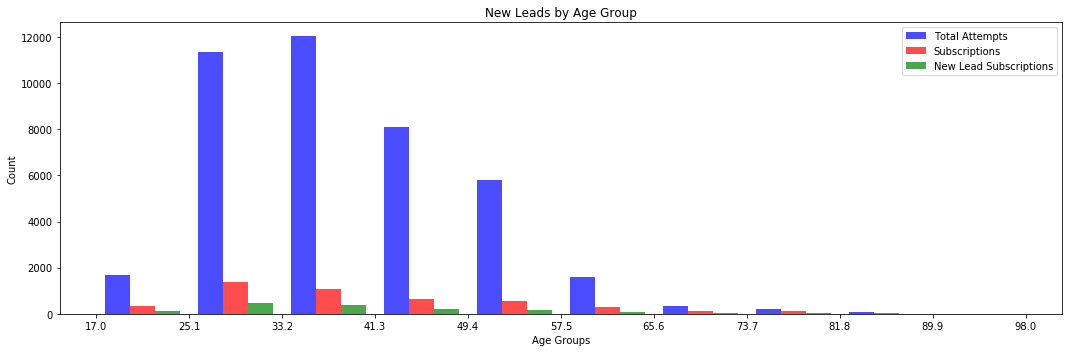

In [259]:
#plots the histogram
colors = ['b','r','g']

fig, ax1 = plt.subplots(figsize=(15,5))
ax1.hist([y1,y2,y3],color=colors, alpha = 0.7, bins=bin_edges, label=['Total Attempts', 'Subscriptions', 'New Lead Subscriptions'])
#ax1.set_xlim(-10,10)

ax1.set_ylabel("Count")
ax1.set_xlabel("Age Groups")

plt.xticks(bin_edges)
plt.legend(loc='upper right')
plt.title("New Leads by Age Group")
plt.tight_layout()
plt.show()

In [260]:
#Creating 4 age bins between the ranges below
pd.cut(df['age'], 4).dtypes

CategoricalDtype(categories=[(16.919, 37.25], (37.25, 57.5], (57.5, 77.75], (77.75, 98.0]]
              ordered=True)

In [261]:
df['age_bin'] = pd.cut(df['age'], 4, labels = [0,1,2,3])

In [265]:
#creating new flags for subscriptions in conjunction with attempt type
df['new_lead_y'] = np.where((df.new_lead == 1)&(df.y == 1),1,0)
df['new_prospect_y'] = np.where((df.new_prospect == 1)&(df.y == 1),1,0)
df['old_prospect_y'] = np.where((df.old_prospect == 1)&(df.y == 1),1,0)

Plotting subscriptions by attempt type we notice old prospects begin subscribing as late as November 2008 but their rate of success is higher than other types starting in 2009. This is indication that this segment behaves differently than others

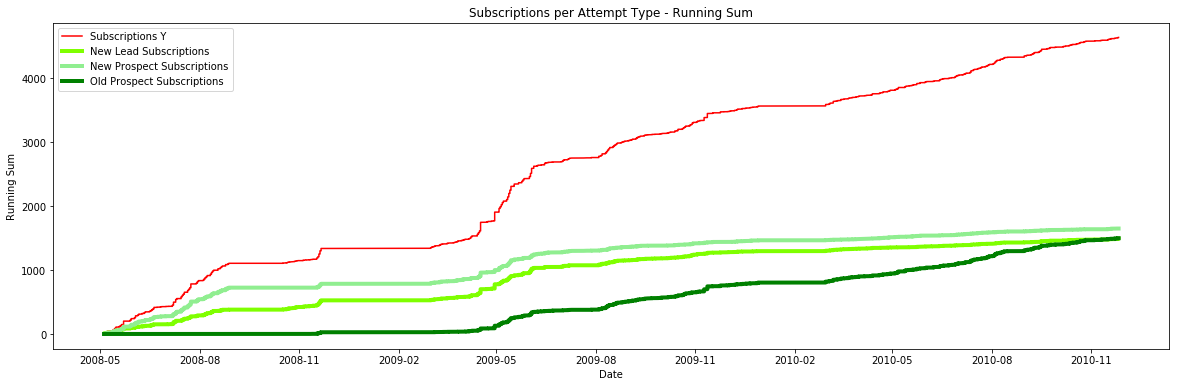

In [347]:
plt.figure(figsize=(20,6))
plt.plot(df.Date, np.cumsum(y), c='red', label = 'Subscriptions Y')
plt.plot(df.Date, np.cumsum(df.new_lead_y), c='chartreuse', linewidth = linewidth, label = 'New Lead Subscriptions')
plt.plot(df.Date, np.cumsum(df.new_prospect_y), c='lightgreen', linewidth = linewidth, label = 'New Prospect Subscriptions')
plt.plot(df.Date, np.cumsum(df.old_prospect_y), c='green', linewidth = linewidth, label = 'Old Prospect Subscriptions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Running Sum')
plt.title("Subscriptions per Attempt Type - Running Sum")
plt.show()

Only 1422 old prospects were attempted until May 2009 out of a total 5625 in the complete timeframe

In [277]:
print("Total Number of Old Prospects prior to May 2009")
df_temp = df[df['Date'] < '2009-05-01']
df_temp = df_temp[['year', 'month', 'old_prospect']]
df_temp[['year', 'month', 'old_prospect']].groupby(['year','month']).sum()['old_prospect'].sum()

Total Number of Old Prospects prior to May 2009


1422

In [270]:
cat_vars = ['job', 'education', 'marital', 'default', 'housing',
       'loan', 'contact', 'month_last_contact', 'day_of_week_last_contact', 
            'year', 'month', 'poutcome']

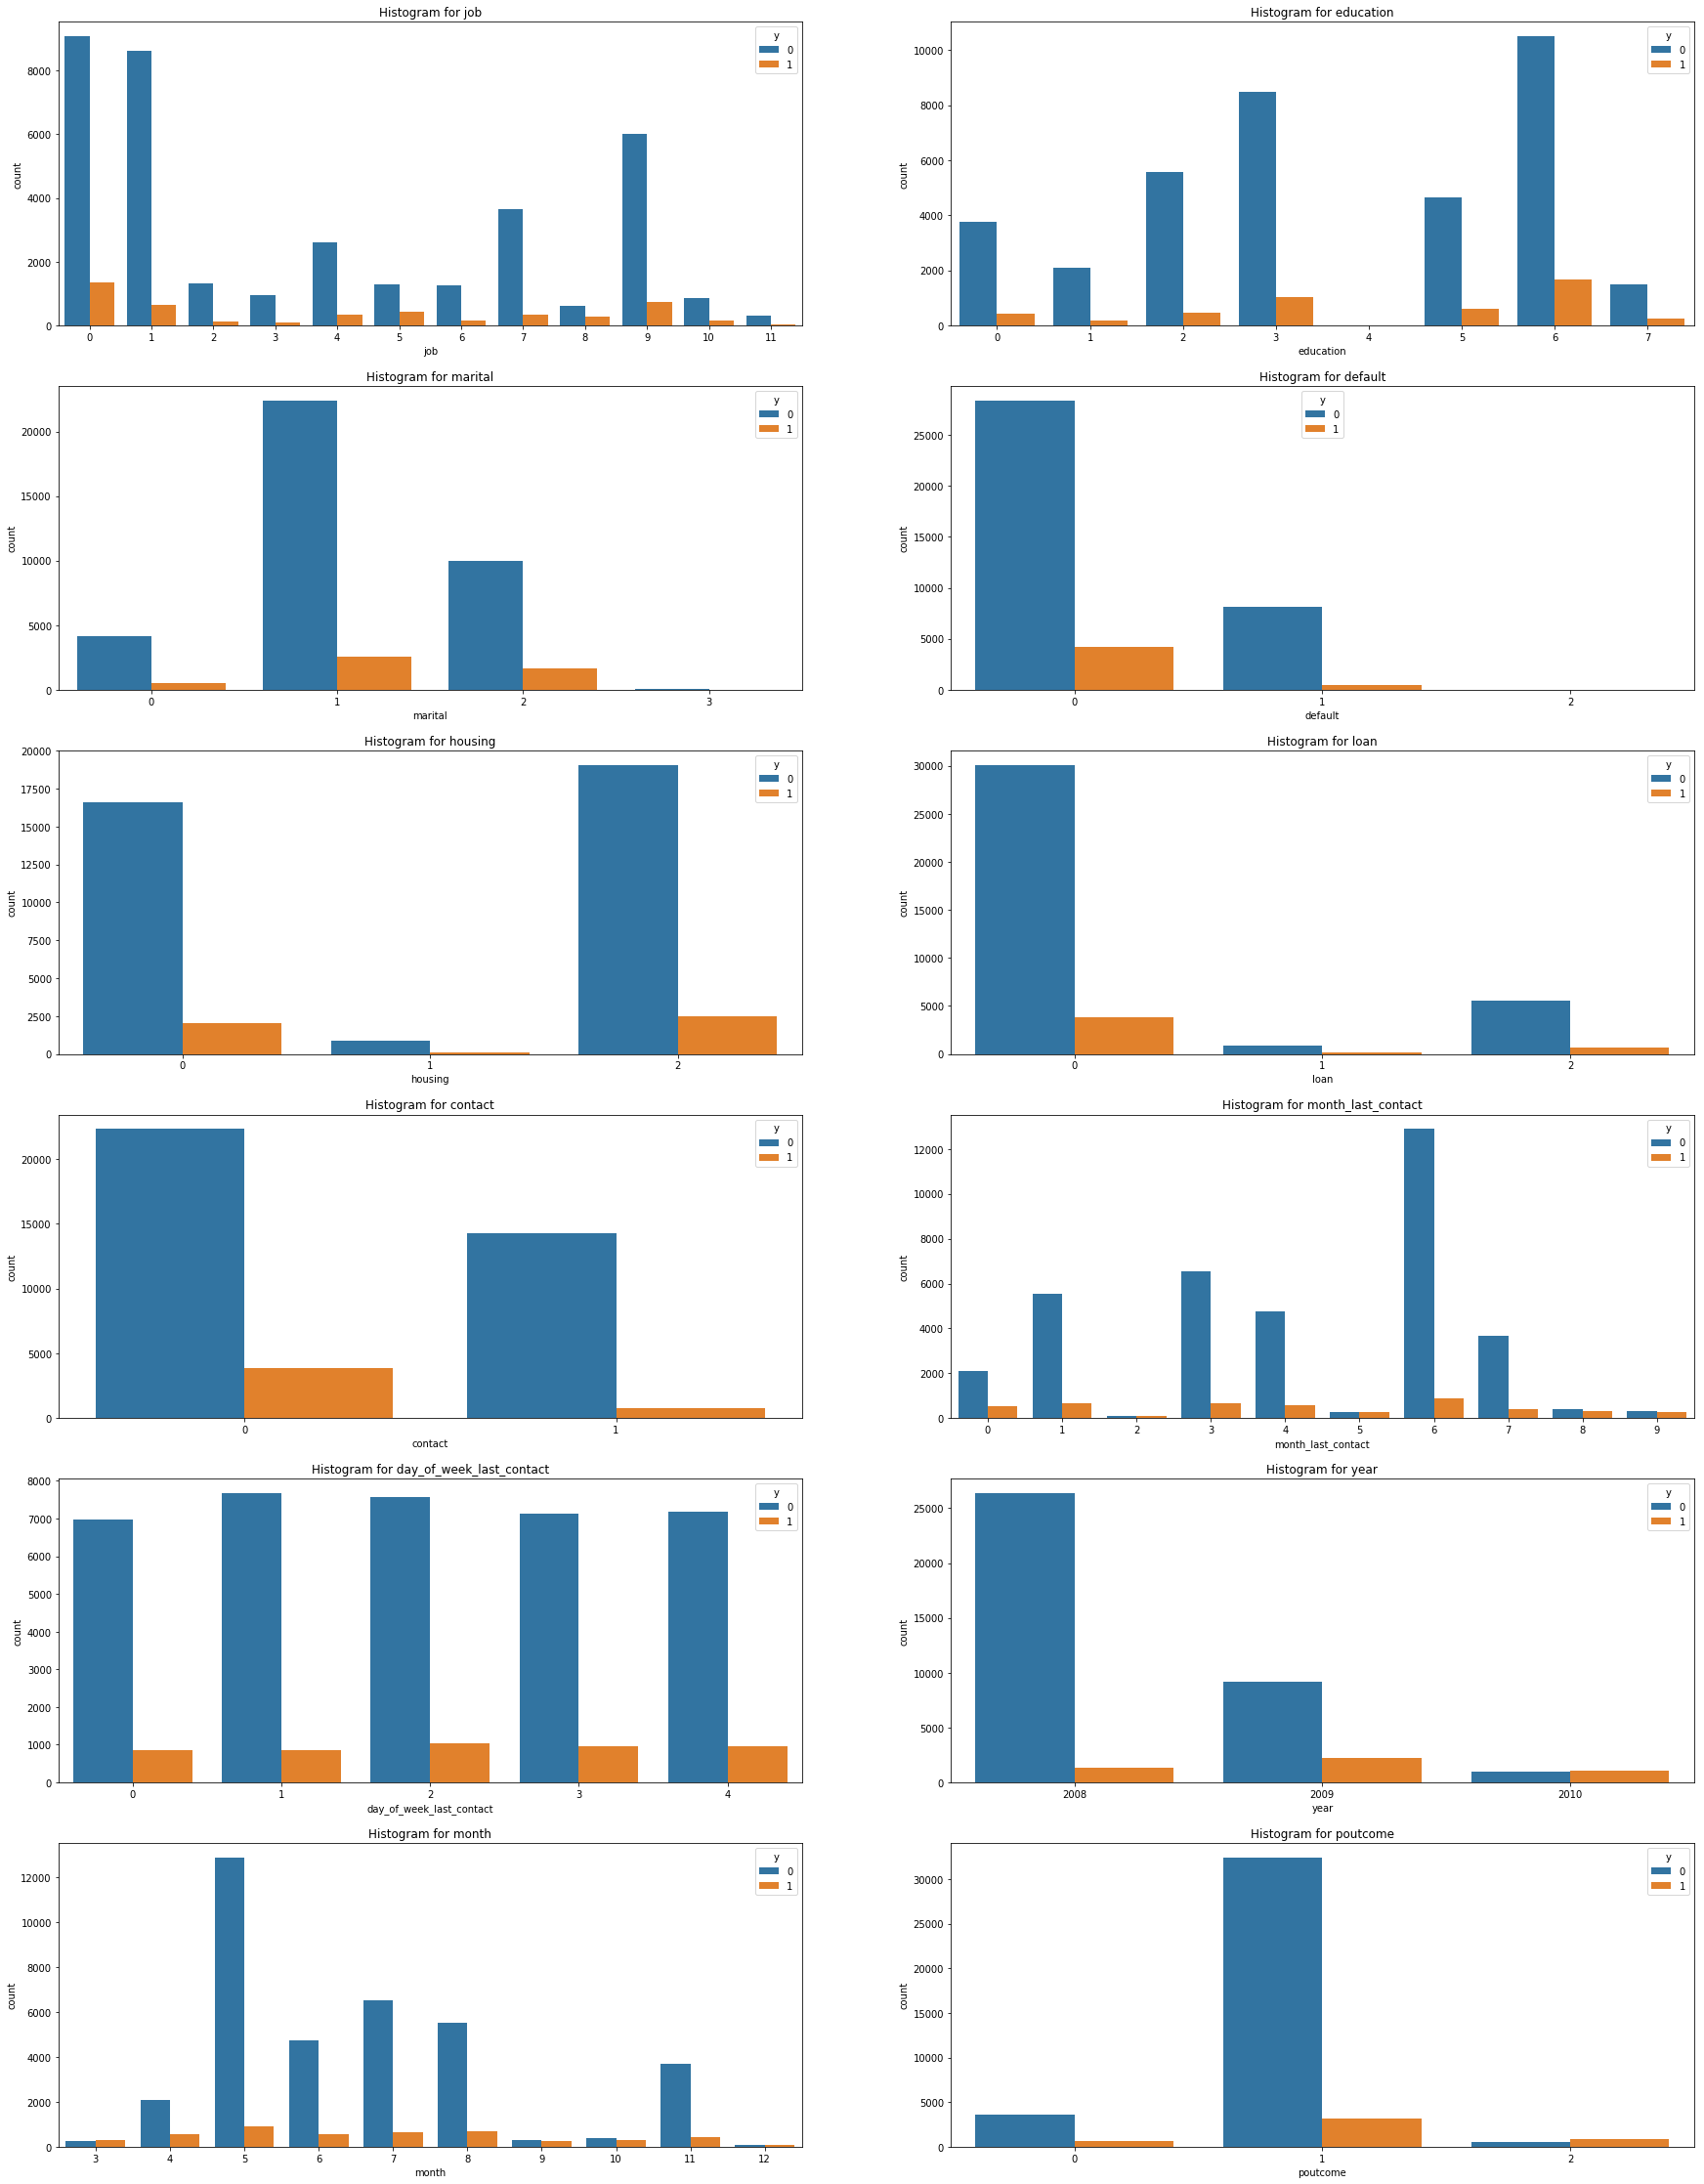

In [278]:
fig, axes = plt.subplots(6,2, sharex=False, sharey=False, figsize=(30,40), squeeze=False)

for ax, feature in zip(axes.flat, cat_vars):
    
    sns.countplot(x=feature, y=None,
                hue="y",
                data=df,
                #ci="sd",
                ax=ax)
    ax.set_title("Histogram for %s" %(str(feature)))
    ax.legend

plt.show()

Outcome was non existent for the majority of attempts as most attempts were made on new customers. But among previous subscribers, attempts were very successful (column 2 of poutcome). This indicates we might be able to predict future subscriptions as a function of old subscriptions, for older leads/prospects. Let's investigate this further:

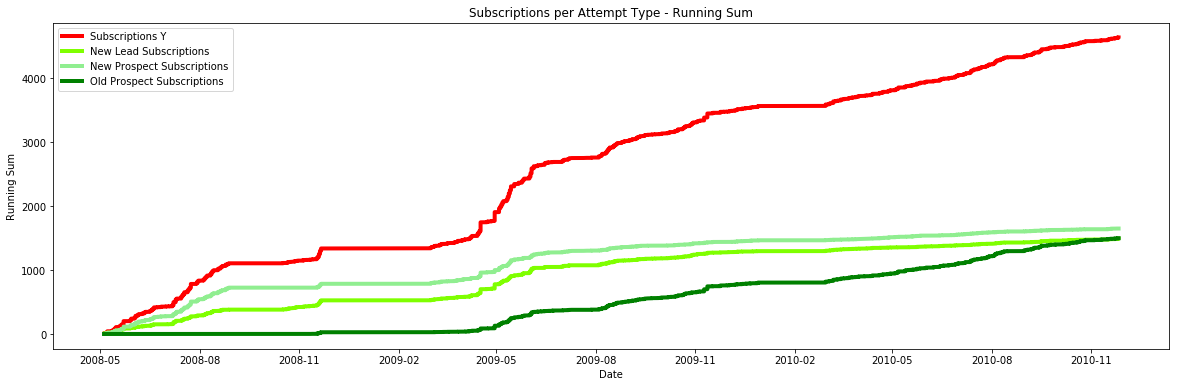

In [349]:
plt.figure(figsize=(20,6))
plt.plot(df.Date, np.cumsum(y), c='red', linewidth = linewidth, label = 'Subscriptions Y')
plt.plot(df.Date, np.cumsum(df.new_lead_y), c='chartreuse', linewidth = linewidth, label = 'New Lead Subscriptions')
plt.plot(df.Date, np.cumsum(df.new_prospect_y), c='lightgreen', linewidth = linewidth,  label = 'New Prospect Subscriptions')
plt.plot(df.Date, np.cumsum(df.old_prospect_y), c='green', linewidth = linewidth, label = 'Old Prospect Subscriptions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Running Sum')
plt.title("Subscriptions per Attempt Type - Running Sum")
plt.show()

In [295]:
#temp_df = df[['campaign', 'previous', 'poutcome', 'pdays','y']]
#sns.pairplot(temp_df, hue='y', height = 8)
#plt.show()

In [296]:
#using new customer as hue
#temp_df = df[['campaign', 'previous', 'poutcome', 'pdays','y', 'new_lead']]
#sns.pairplot(temp_df, hue='new_lead', height = 8)

Let's investigate further the relationship between previous campaign attempts and current campaign attempts

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


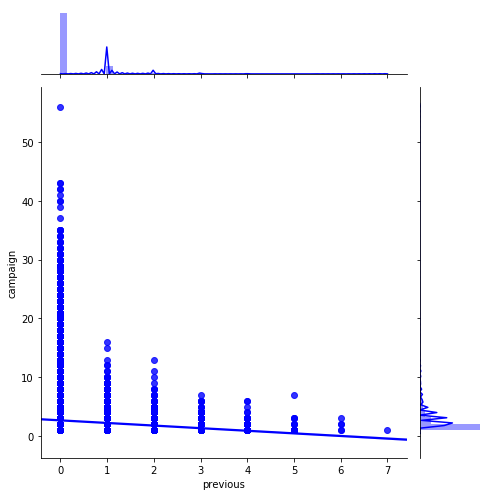

In [293]:
sns.jointplot("previous", "campaign", data=df, kind="reg",color="b", height=7)

In [294]:
print("Total attempts in current campaign far outweight attempts in previous campaign")
print("Previous campaign attempts to current campaign attempts ratio:", np.sum(df['previous'])/np.sum(df['campaign']))

Total attempts in current campaign far outweight attempts in previous campaign
Previous campaign attempts to current campaign attempts ratio: 0.0673638822172211


In [ ]:
#Look at trend in subscriptions vs previously successful contacts

In [367]:
#looking up poutcome codes
cat_lookup(d,df, "poutcome")

[('failure', 0), ('nonexistent', 1), ('success', 2)]

In [335]:
df['prev_subscr_flag'] = np.where((df['poutcome'] == 2), 1, 0)
df['cust_retention_flag'] = np.where((df['poutcome']==2)&(df['y']==1), 1, 0)
df['cust_acquisition_flag'] = np.where((df['poutcome'] == 1)&(df['y']==1), 1, 0)
df['prospect_conversion_flag'] = np.where((df['poutcome'] == 0)&(df['y']==1), 1, 0)

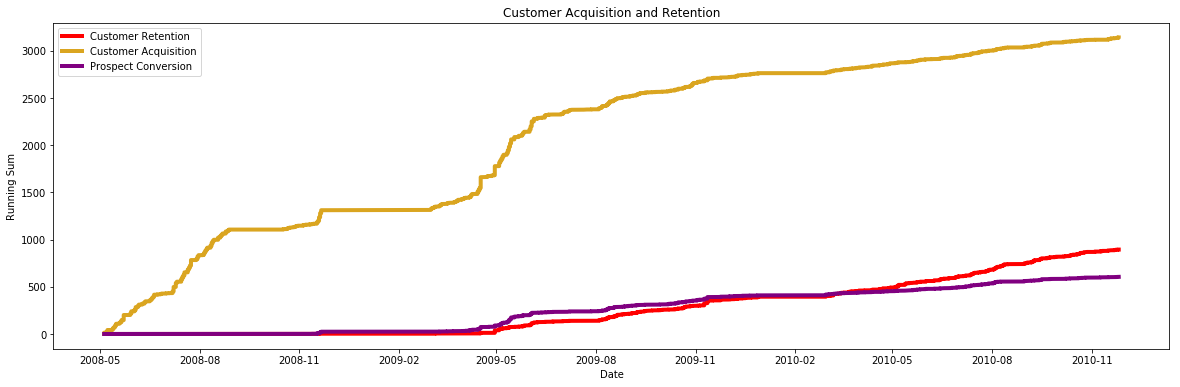

In [353]:
plt.figure(figsize=(20,6))
plt.plot(df.Date, np.cumsum(df.cust_retention_flag), c='red', linewidth = linewidth, label = 'Customer Retention')
plt.plot(df.Date, np.cumsum(df.cust_acquisition_flag), c='goldenrod', linewidth = linewidth,label='Customer Acquisition')
plt.plot(df.Date, np.cumsum(df.prospect_conversion_flag), c='purple',linewidth = linewidth, label = 'Prospect Conversion')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Running Sum')
plt.title("Customer Acquisition and Retention")
plt.show()

In [332]:
print("Customer Retention: repeat subscriptions to total attempts to previous customers: ", df[df['poutcome'] == 2]['y'].sum()/len(df[df['poutcome'] == 2]['y']))

Customer Retention: repeat subscriptions to total attempts to previous customers:  0.651128914785142


Analyzing and creating features for job

In [373]:
jobs = cat_lookup(d,df, 'job')

In [376]:
[i[0] for i in jobs]

['admin.',
 'blue-collar',
 'entrepreneur',
 'housemaid',
 'management',
 'retired',
 'self-employed',
 'services',
 'student',
 'technician',
 'unemployed',
 'unknown']

AttributeError: 'NoneType' object has no attribute 'update'

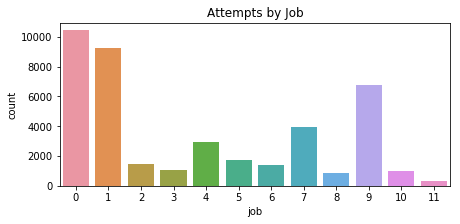

In [377]:
plt.figure(figsize=(7,3))
g = sns.countplot(x='job', y=None, data=df)
plt.title("Attempts by Job")
g.set(xticks=[i[0] for i in jobs])
#plt.xticks = jobs
plt.show()

In [ ]:
#Creating new features for categorical features

In [378]:
cols = ['job', 'marital', 'education', 'default', 'housing','loan', 'contact', 'age_bin']

In [379]:
import itertools
combos = []
for r in range(2,8):
    combos+= [i for i in list(itertools.combinations(cols, r))]

In [380]:
def create_cat_features(df, combos, pred_var, operation):
    
    if operation == 'sum':
    
        for combo in combos:
            df_temp = df[list(combo) + [pred_var]].groupby(list(combo)).sum().reset_index(drop=0)
            combo_name = pred_var +'-'+'-'.join(combo)
            df_temp.rename(columns = {pred_var:combo_name}, inplace=True)
            df = df.merge(df_temp, how='left', on=list(combo))
    
    elif operation == 'avg':
        
        for combo in combos:
            df_temp = df[list(combo) + [pred_var]].groupby(list(combo)).mean().reset_index(drop=0)
            combo_name = pred_var +'-'+'-'.join(combo)
            df_temp.rename(columns = {pred_var:combo_name}, inplace=True)
            df = df.merge(df_temp, how='left', on=list(combo))
    
    else:
        print("You have entered the wrong operation")
        print("Please enter sum or avg")
    
    return df

In [381]:
new_df_y = create_cat_features(df, combos, 'y', 'sum')

In [383]:
new_df_y.shape

(41188, 334)

In [384]:
new_df_camp = create_cat_features(df, combos, 'campaign', 'avg')

In [385]:
new_df_camp.shape

(41188, 334)

In [386]:
new_df_prev = create_cat_features(df, combos, 'previous', 'avg')

In [387]:
new_df_prev.shape

(41188, 334)

Econometric Figures

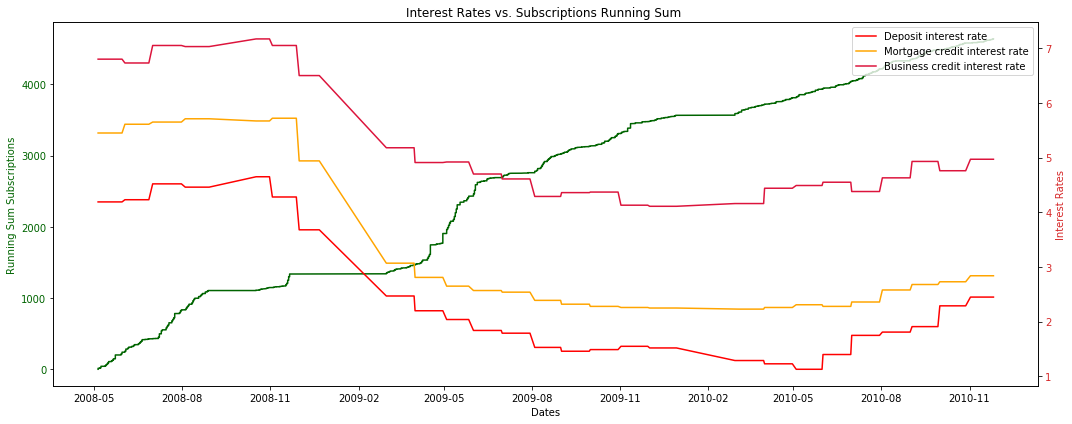

In [392]:
fig, ax1 = plt.subplots(figsize = (15,6))

#color = 'tab:green'
ax1.set_xlabel('Dates')
ax1.set_ylabel('Running Sum Subscriptions', color='darkgreen')
ax1.plot(df.Date, np.cumsum(y), color='darkgreen', label = 'Subscriptions Running Sum')
ax1.tick_params(axis='y', labelcolor='darkgreen')

ax2 = ax1.twinx() 

color = 'tab:red'
ax2.set_ylabel('Interest Rates', color=color)  # we already handled the x-label with ax1
#ax2.plot(df.Date, df['Consumer credit'], color=color)
ax2.plot(df.Date, df['Deposit interest rate'], color = 'red')
ax2.plot(df.Date, df['Mortgage credit interest rate'], color = 'orange')
ax2.plot(df.Date, df['Business credit interest rate'], color = 'crimson')
ax2.tick_params(axis='y', labelcolor=color)
plt.legend()

plt.title("Interest Rates vs. Subscriptions Running Sum ")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
'Consumer credit', 'Deposit interest rate','Mortgage credit interest rate', 'Business credit interest rate',

AttributeError: 'DataFrame' object has no attribute 'customer_acquisition'

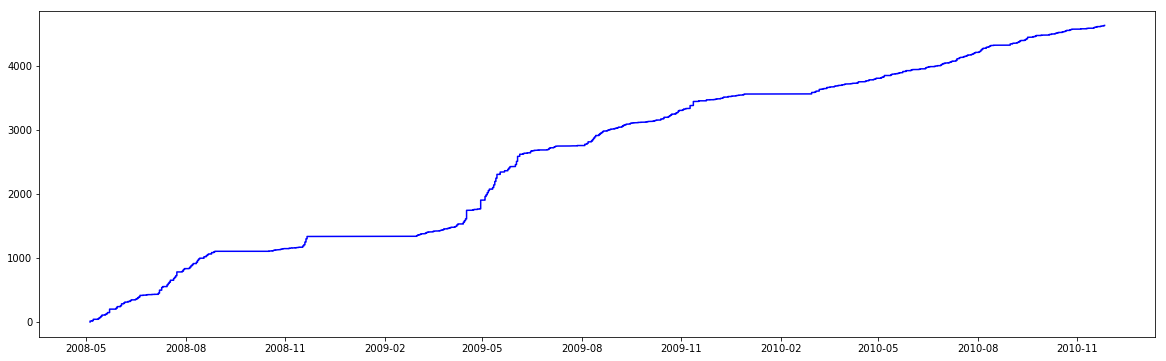

In [394]:
plt.figure(figsize=(20,6))
plt.plot(df.Date, np.cumsum(y), c='blue')
plt.plot(df.Date, np.cumsum(df.customer_acquisition), c='red')
#plt.plot(df.Date, np.cumsum(df.repeat_customer)/np.cumsum(df.new_customer), c='yellow')
plt.show()

In [ ]:
df[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed']].describe()

In [ ]:
df[['Employment', 'Unemployment rate', 'Current account balance', 'Exports',
       'FDI', 'Foreign exchange reserves', 'Government expenditure',
       'Budget balance', 'Labor cost', 'Exchange rate to USD', 'Minimum wage',
       'Government debt', 'Private sector credit', 'Business credit',
       'Household credit', 'Mortgage credit', 'Gross Domestic Product (GDP)',
       'Consumer Price Index (CPI)', 'Money supply (broad money)',
       'Household consumption', 'Investment', 'Economic growth',
       'Consumption growth', 'Investment as percent of GDP',
       'Investment growth', 'Consumption as percent of GDP',
       'Inflation monthly', 'Inflation annual', 'Retail sales',
       'Business confidence survey', 'Consumer confidence survey',
       'Economic growth Q-on-Q']].describe()

In [ ]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(corr, ax=ax, cmap = 'PuOr', cbar=True)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
df.columns

In [ ]:
#COntinue financial modeling - do more figures and also do a calculation and projection 
#of interest rate as cost and financial contribution of cistomer acquisition and retention

In [ ]:
#do a projection of average cost per new vs old prospect lead
#do a projection of pdays and previous vs campaign contacts to predict a cost

In [ ]:
#run feature selection on the newly augmented datasets
#do a pk on customers to analyze by customer ID

In [ ]:
#Create a regression for call duration with 
#the new data AFTER feature selection and see if that can be used in stacking ensemb;e

In [ ]:
#do a time series analysis with ARMA/ARIMA especially using the prospects 

In [ ]:
#create new fields to reflect new lead and prospects temperature/freshness
#maybe use log regression predict proba to determine lead temperature

In [ ]:
#stacking ensemble: use classification for new leads, duration regression, arima for repeats

In [ ]:
fig, ax1 = plt.subplots(figsize = (15,6))

color = 'tab:red'
ax1.set_xlabel('Dates')
ax1.set_ylabel('Running Sum Subscriptions', color=color)
ax1.plot(df.Date, np.cumsum(y), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:green'
ax2.set_ylabel('Interest Rates', color=color)  # we already handled the x-label with ax1
#ax2.plot(df.Date, df['Consumer credit'], color=color)
ax2.plot(df.Date, df['emp.var.rate'], color = 'green')
ax2.plot(df.Date, df['Gross Domestic Product (GDP)'], color = 'chartreuse')
ax2.plot(df.Date, df['Money supply (broad money)'], color = 'lightgreen')
ax2.tick_params(axis='y', labelcolor=color)
plt.legend()

plt.title("Interest Rates vs. Subscriptions Running Sum ")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
#analyze housing, loan, default and even job types with respect to economic factors

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [ ]:
lr = LinearRegression()

In [ ]:
y = df['cum_sum_y']
X = df.drop(columns = ['y', 'Date', 'duration'])

In [ ]:
X = X[['Employment', 'Unemployment rate', 'Current account balance', 'Exports',
       'FDI', 'Foreign exchange reserves', 'Government expenditure',
       'Budget balance', 'Labor cost', 'Exchange rate to USD', 'Minimum wage',
       'Government debt', 'Private sector credit', 'Business credit',
       'Household credit', 'Mortgage credit', 'Gross Domestic Product (GDP)',
       'Consumer Price Index (CPI)', 'Money supply (broad money)',
       'Household consumption', 'Investment', 'Economic growth',
       'Consumption growth', 'Investment as percent of GDP',
       'Investment growth', 'Consumption as percent of GDP',
       'Inflation monthly', 'Inflation annual', 'Retail sales',
       'Business confidence survey', 'Consumer confidence survey',
       'Economic growth Q-on-Q']]

In [ ]:
y = df['duration']
X = df.drop(columns = ['y', 'Date', 'duration'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
lr.fit(X_train, y_train)

In [ ]:
r2_score(y_test, lr.predict(X_test))